## **PyMC3运行测试: 线性趋势断点估计**

In [1]:
import numpy as np
import matplotlib.pyplot as plt

生成连续的两段线性趋势样本$x$和$y$, 如下所示:

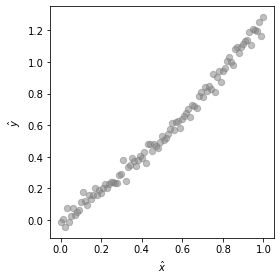

In [2]:
x = np.linspace(0.0, 1.0, 101)

x_left = x[np.where(x <= 0.5)]
x_right = x[np.where(x > 0.5)]

np.random.seed(2)
y_left = 1.0 * x_left + 0.0 + np.random.normal(loc=0, scale=0.03, size=x_left.shape)
y_right = 1.5 * (x_right - 0.5) + 0.5 + np.random.normal(loc=0, scale=0.03, size=x_right.shape)

y = np.r_[y_left, y_right]

# 画图
plt.figure(figsize=(4, 4))
plt.scatter(x, y, s=40, alpha=.5, color="grey")
plt.xlabel("$\hat{x}$")
plt.ylabel("$\hat{y}$")
plt.tight_layout()

接下来, 采用PyMC库进行参数的贝叶斯估计

In [3]:
import pymc3 as pm

WARN: Could not locate executable g77
WARN: Could not locate executable f77
WARN: Could not locate executable ifort
WARN: Could not locate executable ifl
WARN: Could not locate executable f90
WARN: Could not locate executable DF
WARN: Could not locate executable efl


WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [4]:
# 初始化一个贝叶斯模型实例
basic_model = pm.Model()

# 定义模型中待估计的参数
with basic_model:
    c = pm.Uniform("c", lower=0.2, upper=0.8)
    a1 = pm.Normal("a1", mu=1.0, sigma=1.0)
    b1 = pm.Normal("b1", mu=0.0, sigma=1.0)
    a2 = pm.Normal("a2", mu=1.0, sigma=1.0)
    b2 = pm.Normal("b2", mu=0.0, sigma=1.0)
    s = pm.Exponential("sampling_noise_std", 3)

In [5]:
with basic_model:
    # 根据参数确定线性趋势参数
    a = pm.math.switch(x < c, a1, a2)  # 每个x值对应的参数构成的序列
    b = pm.math.switch(x < c, b1, b2)
    
    obs = pm.Normal("obs", a * x + b, s, observed=y)
    
basic_model.basic_RVs

[c_interval__ ~ TransformedDistribution,
 a1 ~ Normal,
 b1 ~ Normal,
 a2 ~ Normal,
 b2 ~ Normal,
 sampling_noise_std_log__ ~ TransformedDistribution,
 obs ~ Normal]

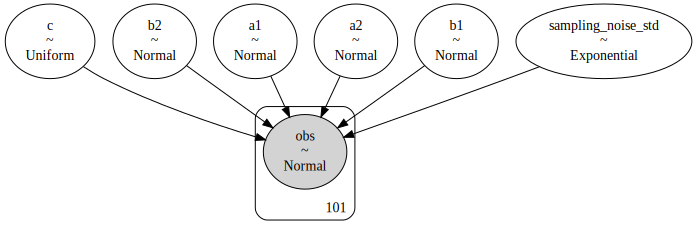

In [6]:
pm.model_graph.model_to_graphviz(basic_model)

In [7]:
with basic_model:
    step = pm.Metropolis()  # 采用的迭代函数.
    trace = pm.sample(10000, tune=20000, step=step, return_inferencedata=False, cores=1, chains=1)

Sampling 1 chain for 20_000 tune and 10_000 draw iterations (20_000 + 10_000 draws total) took 21 seconds.
d:\Anaconda3\envs\pymc3_bayesian_env\lib\site-packages\arviz\data\base.py:220: UserWarning: More chains (10000) than draws (6). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
Only one chain was sampled, this makes it impossible to run some convergence checks


In [8]:
c_samples = trace["c"]
a1_samples = trace["a1"]
b1_samples = trace["b1"]
a2_samples = trace["a2"]
b2_samples = trace["b2"]
error = trace["sampling_noise_std"]

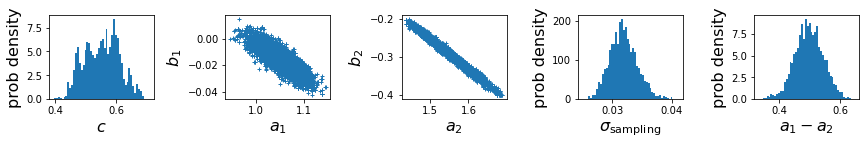

In [9]:
plt.figure(figsize=(12, 2))
plt.subplot(1, 5, 1)
plt.hist(c_samples, bins=50, density=1)
plt.xlabel("$c$", fontsize=16)
plt.ylabel("prob density", fontsize=16)
plt.subplot(1, 5, 2)
plt.scatter(a1_samples, b1_samples, s=10, marker="+", linewidth=1)
plt.xlabel("$a_1$", fontsize=16)
plt.ylabel("$b_1$", fontsize=16)
plt.subplot(1, 5, 3)
plt.scatter(a2_samples, b2_samples, s=10, marker="+", linewidth=1)
plt.xlabel("$a_2$", fontsize=16)
plt.ylabel("$b_2$", fontsize=16)
plt.subplot(1, 5, 4)
plt.hist(error, bins=50, density=1)
plt.xlabel("$\sigma_{\\rm sampling}$", fontsize=16)
plt.ylabel("prob density", fontsize=16)
plt.subplot(1, 5, 5)
plt.hist(a2_samples - a1_samples, bins=50, density=1)
plt.xlabel("$a_1 - a_2$", fontsize=16)
plt.ylabel("prob density", fontsize=16)
plt.tight_layout()